### Explorative Data Analysis of Raw Dataframe
After creation of the raw dataframe with the data_gathering.py script, a look into the given data is necessary. The focus will be missing and/or implausible values, correlations and trends. Technical details on the data will be shortly discussed, as well as decisions on imputation and generation of new features for preprocessing.

In [2]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import pandas as pd
import numpy as np

pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(suppress=True,formatter={'float_kind':'{:0.2f}'.format})

df_raw = pd.read_csv('../Dataset/preprocessed_data/df_final_raw_2015_2023.csv',index_col=0,parse_dates=['date'])
df_raw.info()
df_raw.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3287 entries, 0 to 3286
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             3287 non-null   datetime64[ns]
 1   03668_FD_STRAHL  3287 non-null   float64       
 2   03668_FG_STRAHL  3287 non-null   float64       
 3   03668_SD_STRAHL  3287 non-null   float64       
 4   05792_FD_STRAHL  3287 non-null   float64       
 5   05792_FG_STRAHL  3287 non-null   float64       
 6   05792_SD_STRAHL  3287 non-null   float64       
 7   05856_FD_STRAHL  3287 non-null   float64       
 8   05856_FG_STRAHL  3287 non-null   float64       
 9   05856_SD_STRAHL  3287 non-null   float64       
 10  05705_FD_STRAHL  3287 non-null   float64       
 11  05705_FG_STRAHL  3287 non-null   float64       
 12  05705_SD_STRAHL  3287 non-null   float64       
 13  02290_FD_STRAHL  3287 non-null   float64       
 14  02290_FG_STRAHL  3287 non-null   float64     

,date,03668_FD_STRAHL,03668_FG_STRAHL,03668_SD_STRAHL,05792_FD_STRAHL,05792_FG_STRAHL,05792_SD_STRAHL,05856_FD_STRAHL,05856_FG_STRAHL,05856_SD_STRAHL,...,02290_FD_STRAHL,02290_FG_STRAHL,02290_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,05404_SD_STRAHL,Bruttoleistung,Nettoleistung,Prog_in_MW,Act_in_MW
0,2015-01-01,188.00,188.00,0.00,0.00,694.00,8.40,214.00,214.00,0.00,...,184.00,611.00,7.70,365.00,426.00,1.90,302.87,282.38,0.00,2807.70
1,2015-01-02,76.00,76.00,0.00,0.00,383.00,2.80,251.00,259.00,0.10,...,320.00,414.00,2.60,233.00,281.00,2.00,926.05,782.54,0.00,2813.00
2,2015-01-03,108.00,108.00,0.00,0.00,343.00,1.20,297.00,316.00,0.30,...,253.00,265.00,0.80,194.00,196.00,0.00,20.23,20.23,0.00,6713.30
3,2015-01-04,232.00,233.00,0.00,0.00,252.00,0.00,206.00,207.00,0.00,...,252.00,274.00,1.00,182.00,183.00,0.00,0.00,0.00,13422.30,4321.50
4,2015-01-05,157.00,485.00,6.20,0.00,591.00,2.90,223.00,223.00,0.00,...,279.00,457.00,3.50,344.00,392.00,1.80,502.85,476.85,18801.30,20532.60


In [258]:
df_raw.describe()

,date,03668_FD_STRAHL,03668_FG_STRAHL,03668_SD_STRAHL,05792_FD_STRAHL,05792_FG_STRAHL,05792_SD_STRAHL,05856_FD_STRAHL,05856_FG_STRAHL,05856_SD_STRAHL,...,02290_FD_STRAHL,02290_FG_STRAHL,02290_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,05404_SD_STRAHL,Bruttoleistung,Nettoleistung,Prog_in_MW,Act_in_MW
count,3287,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,...,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00,3287.00
mean,2019-07-01 23:59:59.999999744,497.45,1168.54,-1.72,140.30,1190.96,-43.72,501.73,1183.81,-10.18,...,468.60,1221.12,-6.98,465.10,1195.08,-10.38,3491.91,3114.93,113206.85,111891.67
min,2015-01-01 00:00:00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,...,-999.00,-999.00,-999.00,-999.00,-999.00,-999.00,0.00,0.00,0.00,0.00
25%,2017-04-01 12:00:00,242.00,376.00,0.60,-999.00,638.00,0.60,271.00,421.50,0.40,...,261.00,508.00,0.80,256.00,438.50,0.70,335.00,310.18,43638.65,41035.55
50%,2019-07-02 00:00:00,467.00,1013.00,4.30,300.00,1146.00,4.90,474.00,1013.00,4.40,...,451.00,1031.00,4.80,454.00,1012.00,4.60,1085.70,991.50,105962.70,102902.40
75%,2021-09-30 12:00:00,789.00,1877.00,9.40,798.50,1865.00,8.90,765.00,1918.50,9.40,...,752.50,1917.00,9.30,771.00,1938.00,9.60,3561.81,3200.07,171325.65,171261.25
max,2023-12-31 00:00:00,1562.00,3351.00,15.70,3167.00,3553.00,16.00,1559.00,3218.00,15.70,...,1612.00,3286.00,15.50,1572.00,3271.00,15.40,118595.94,106095.63,330696.10,337090.00
std,NaN,415.57,904.43,83.86,858.26,991.40,216.87,413.89,913.37,124.25,...,474.23,887.86,111.60,478.14,911.34,125.45,6297.72,5574.79,76766.12,78022.81


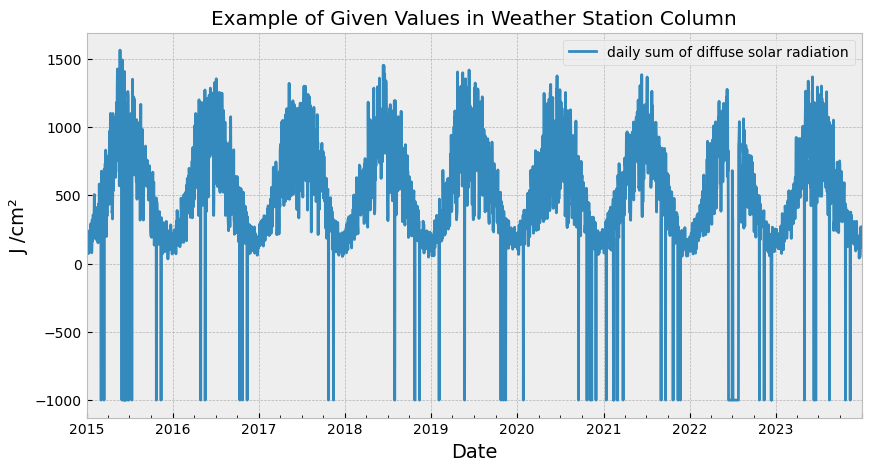

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
df_raw.plot(x='date',y='03668_FD_STRAHL',figsize=(10,5),label='daily sum of diffuse solar radiation',title='Example of Given Values in Weather Station Column',ax=ax) #example of stations-file for -999 values
plt.ylabel('J /cm²',fontsize=14)
plt.xlabel('Date',fontsize=14)
plt.show()

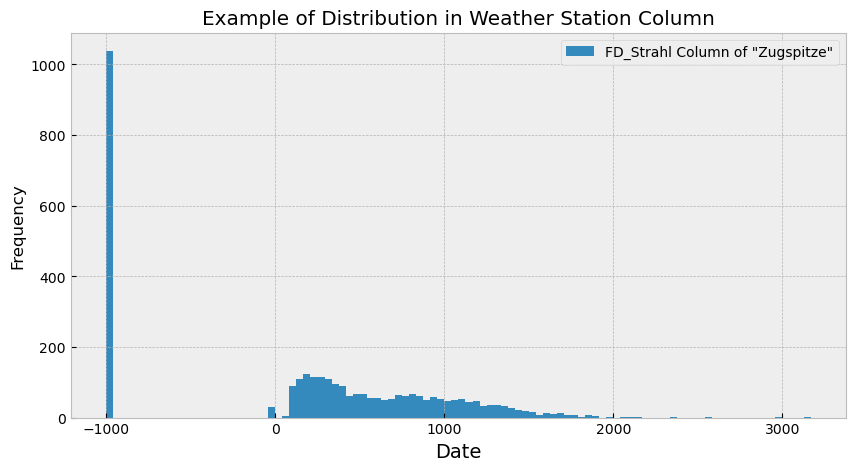

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
df_raw.loc[:,'05792_FD_STRAHL'].plot(kind='hist',figsize=(10,5),bins=100,
                                     label='FD_Strahl Column of "Zugspitze"',title='Example of Distribution in Weather Station Column')
plt.xlabel('Date',fontsize=14)
ax.legend()
plt.show()
# values to be imputed: -999, 0 , since no solar radiation at all seems physically not plausible

<Axes: xlabel='date'>

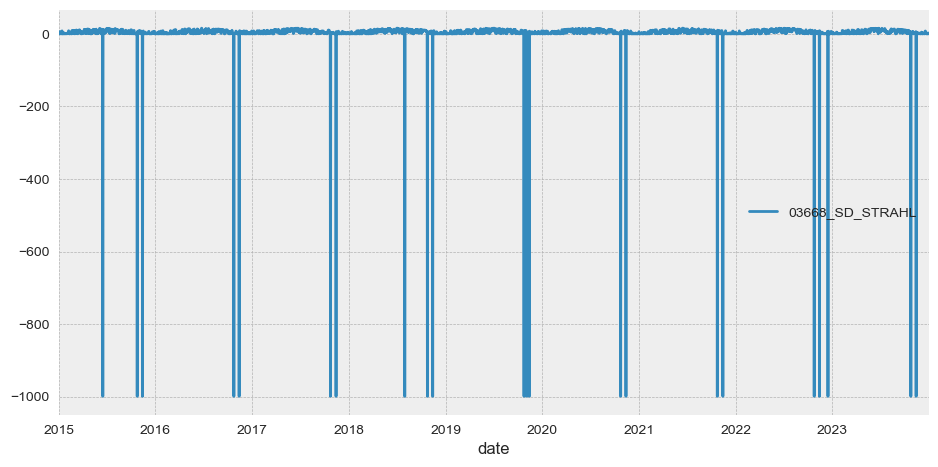

In [261]:
df_raw.plot(x='date',y='03668_SD_STRAHL',figsize=(10,5))

<Axes: ylabel='Frequency'>

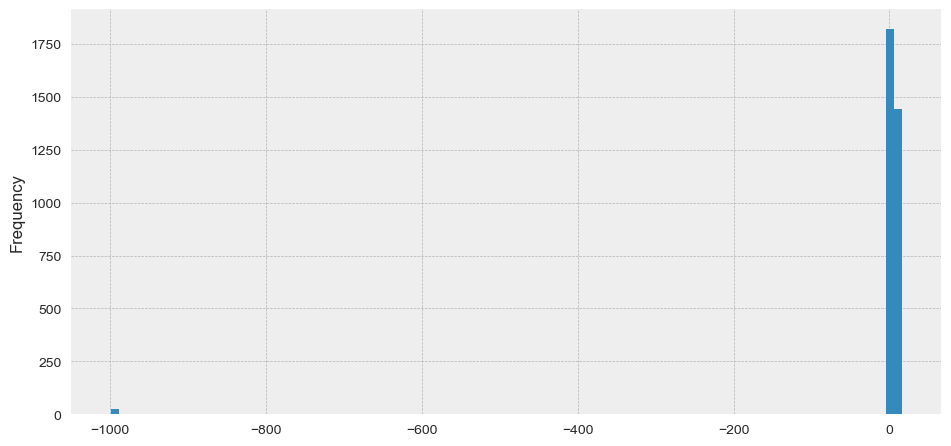

In [262]:
df_raw.loc[:,'03668_SD_STRAHL'].plot(kind='hist',figsize=(10,5),bins=100)
# values to be imputed: -999

### Actual Produced Solar Energy
Overview of 2015 to 2023 in the state of Bavaria in MW

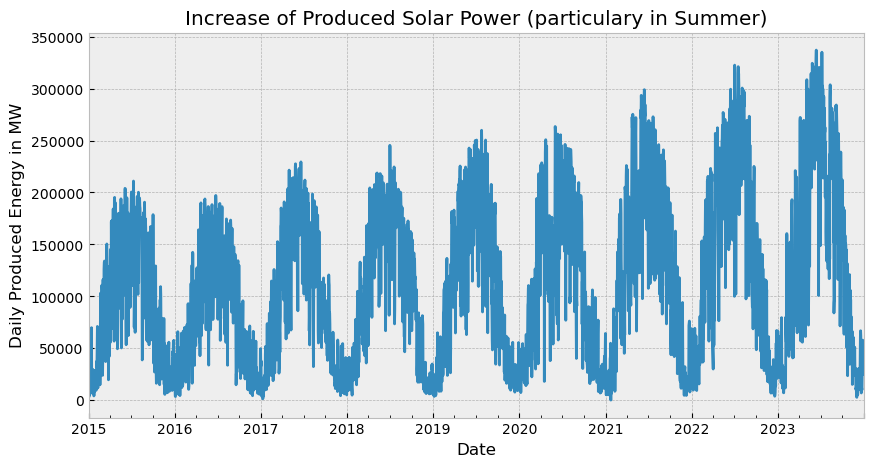

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
df_raw.plot(x='date',y='Act_in_MW',figsize=(10,5),ax=ax,title='Increase of Produced Solar Power (particulary in Summer)') 
ax.get_legend().remove()
plt.ylabel('Daily Produced Energy in MW')
plt.xlabel('Date')
plt.show()

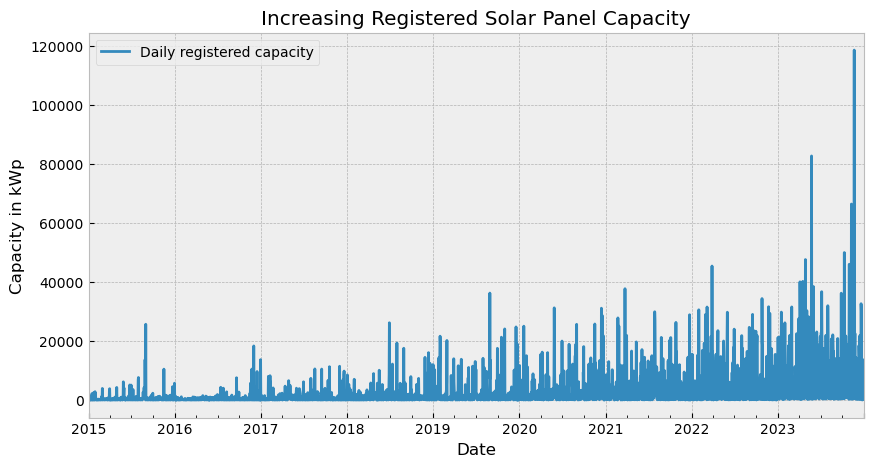

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
df_raw.plot(x='date',y='Bruttoleistung',figsize=(10,5),ax=ax,title='Increasing of Registered Solar Panel Capacity',label='Daily registered capacity') 
plt.ylabel('Capacity in kWp')
plt.xlabel('Date')
plt.show()

In [311]:
df = pd.read_csv('../Dataset/preprocessed_data/df_final_raw_2015_2023.csv',index_col=0,parse_dates=['date'])

df = df.drop('Prog_in_MW',axis=1) # similar to target column, high danger of data leakage

cols_sd =[col for col in df.columns if 'SD' in col]
for col in cols_sd:
    # setting values < 0 (i.a. -999) to NaN
    df.loc[(df.loc[:,col] < 0),col] = pd.NA

cols_fd_fg = [col for col in df.columns if ('FD' in col)|('FG' in col)]
for col in cols_fd_fg:
    # setting values < 1 (-999 and 0) to NaN
    df.loc[(df.loc[:,col] < 1),col] = pd.NA

df.info()
display(df.head())
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 3287 entries, 0 to 3286
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             3287 non-null   datetime64[ns]
 1   03668_FD_STRAHL  3188 non-null   float64       
 2   03668_FG_STRAHL  3241 non-null   float64       
 3   03668_SD_STRAHL  3264 non-null   float64       
 4   05792_FD_STRAHL  2218 non-null   float64       
 5   05792_FG_STRAHL  3027 non-null   float64       
 6   05792_SD_STRAHL  3126 non-null   float64       
 7   05856_FD_STRAHL  3182 non-null   float64       
 8   05856_FG_STRAHL  3229 non-null   float64       
 9   05856_SD_STRAHL  3236 non-null   float64       
 10  05705_FD_STRAHL  3210 non-null   float64       
 11  05705_FG_STRAHL  3222 non-null   float64       
 12  05705_SD_STRAHL  3268 non-null   float64       
 13  02290_FD_STRAHL  3108 non-null   float64       
 14  02290_FG_STRAHL  3245 non-null   float64     

,date,03668_FD_STRAHL,03668_FG_STRAHL,03668_SD_STRAHL,05792_FD_STRAHL,05792_FG_STRAHL,05792_SD_STRAHL,05856_FD_STRAHL,05856_FG_STRAHL,05856_SD_STRAHL,...,05705_SD_STRAHL,02290_FD_STRAHL,02290_FG_STRAHL,02290_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,05404_SD_STRAHL,Bruttoleistung,Nettoleistung,Act_in_MW
0,2015-01-01,188.00,188.00,0.00,NaN,694.00,8.40,214.00,214.00,0.00,...,0.00,184.00,611.00,7.70,365.00,426.00,1.90,302.87,282.38,2807.70
1,2015-01-02,76.00,76.00,0.00,NaN,383.00,2.80,251.00,259.00,0.10,...,0.00,320.00,414.00,2.60,233.00,281.00,2.00,926.05,782.54,2813.00
2,2015-01-03,108.00,108.00,0.00,NaN,343.00,1.20,297.00,316.00,0.30,...,0.00,253.00,265.00,0.80,194.00,196.00,0.00,20.23,20.23,6713.30
3,2015-01-04,232.00,233.00,0.00,NaN,252.00,0.00,206.00,207.00,0.00,...,0.00,252.00,274.00,1.00,182.00,183.00,0.00,0.00,0.00,4321.50
4,2015-01-05,157.00,485.00,6.20,NaN,591.00,2.90,223.00,223.00,0.00,...,7.50,279.00,457.00,3.50,344.00,392.00,1.80,502.85,476.85,20532.60


date                  0
03668_FD_STRAHL      99
03668_FG_STRAHL      46
03668_SD_STRAHL      23
05792_FD_STRAHL    1069
05792_FG_STRAHL     260
05792_SD_STRAHL     161
05856_FD_STRAHL     105
05856_FG_STRAHL      58
05856_SD_STRAHL      51
05705_FD_STRAHL      77
05705_FG_STRAHL      65
05705_SD_STRAHL      19
02290_FD_STRAHL     179
02290_FG_STRAHL      42
02290_SD_STRAHL      41
05404_FD_STRAHL     190
05404_FG_STRAHL      65
05404_SD_STRAHL      52
Bruttoleistung        0
Nettoleistung         0
Act_in_MW             0
dtype: int64

In [312]:
cols_fg =[col for col in df.columns if 'FG' in col]
display(df.loc[(df['date'].dt.day==1) & (df['date'].dt.month==1),cols_fg])
print(df.loc[(df['date'].dt.day==1) & (df['date'].dt.month==1),'03668_FG_STRAHL'].median())
print(df.loc[(df.index==365) & (df['date'].dt.day==1) & (df['date'].dt.month==1),cols_fg].sum().median())
((df.loc[(df['date'].dt.day==1) & (df['date'].dt.month==1),'03668_FG_STRAHL'].median())+(df.loc[(df.index==365) & (df['date'].dt.day==1) & (df['date'].dt.month==1),cols_fg].sum().median()))/2

,03668_FG_STRAHL,05792_FG_STRAHL,05856_FG_STRAHL,05705_FG_STRAHL,02290_FG_STRAHL,05404_FG_STRAHL
0,188.00,694.00,214.00,129.00,611.00,426.00
365,190.00,NaN,232.00,120.00,338.00,123.00
731,499.00,730.00,454.00,131.00,641.00,395.00
1096,322.00,317.00,220.00,339.00,329.00,276.00
1461,98.00,747.00,57.00,56.00,198.00,109.00
1826,560.00,697.00,548.00,223.00,635.00,531.00
2192,144.00,663.00,448.00,185.00,397.00,418.00
2557,196.00,698.00,283.00,192.00,612.00,566.00
2922,308.00,662.00,537.00,291.00,597.00,526.00


196.0
156.5


176.25

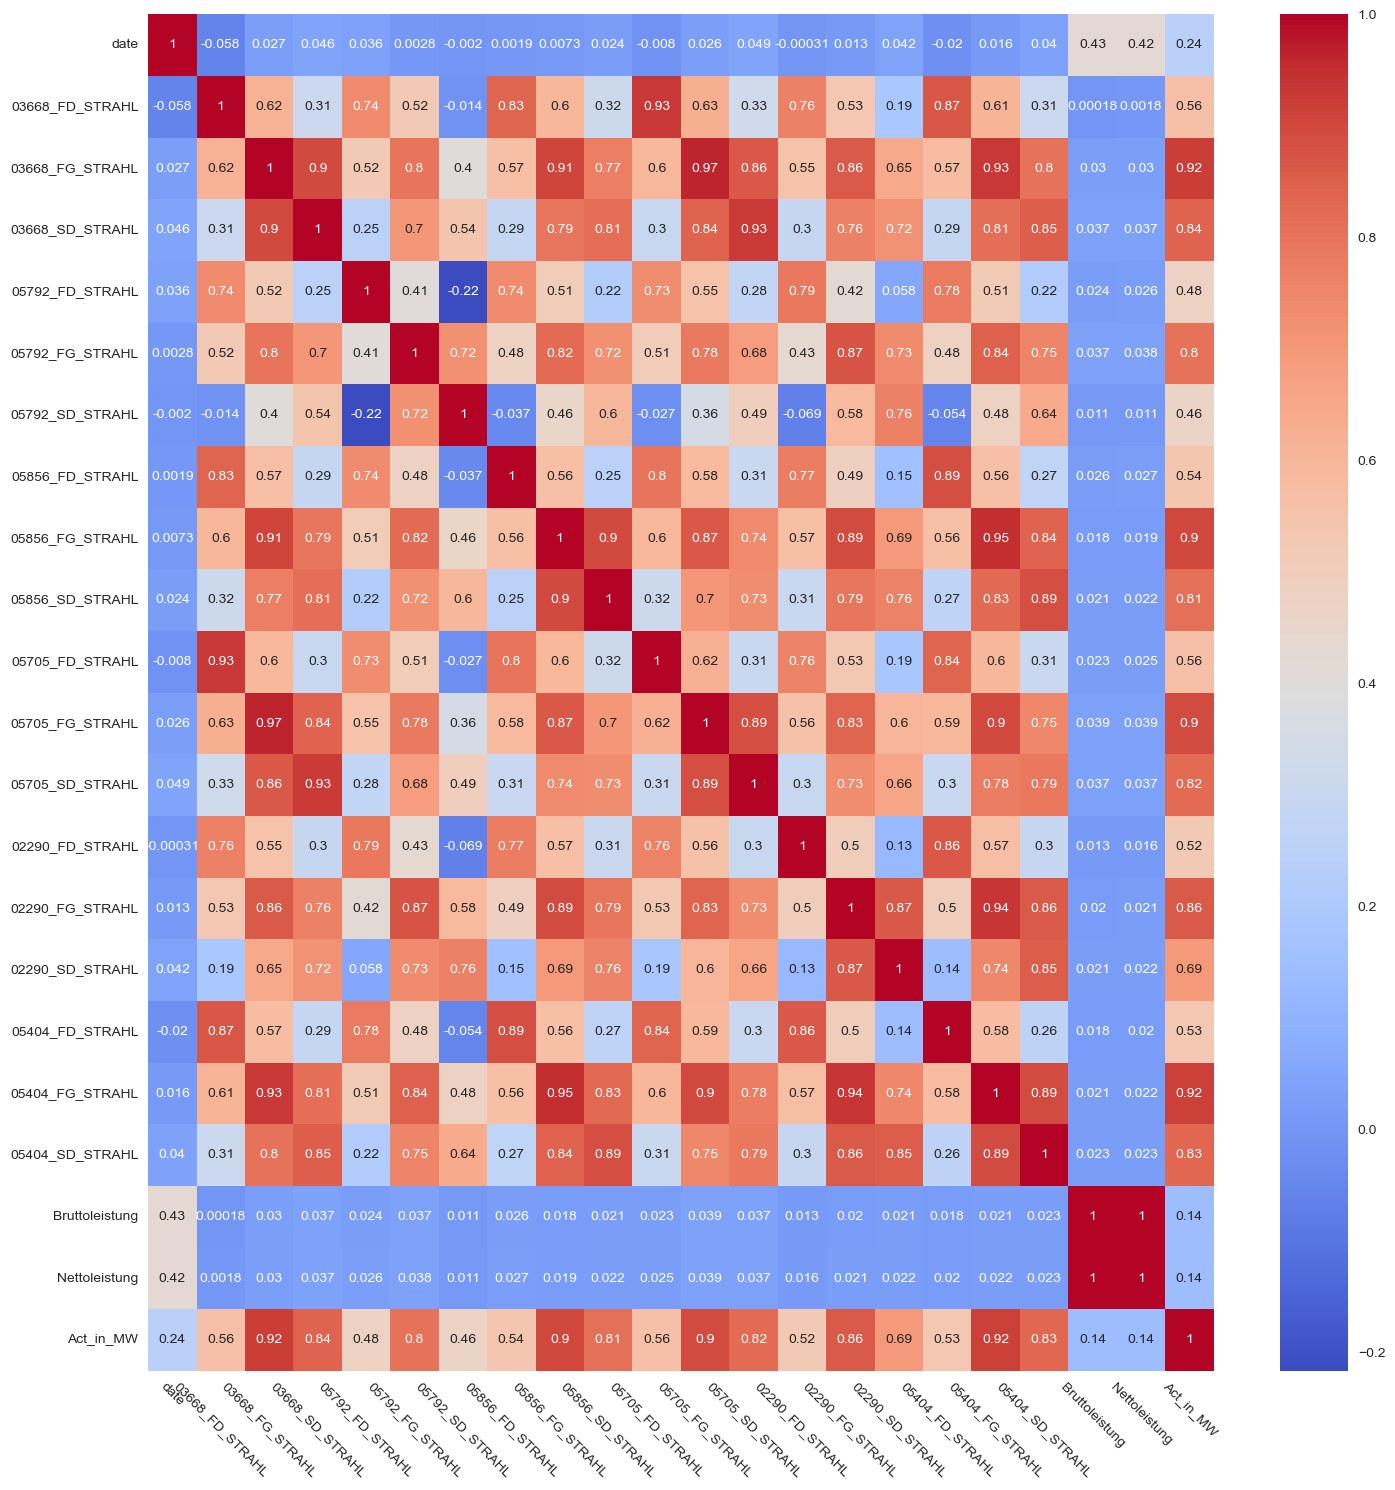

In [313]:
fig,ax=plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,ax=ax)
plt.xticks(rotation=-45)  # Rotate x-axis labels for readability

plt.tight_layout()  # Adjust spacing for readability
plt.show()

0.002346242714666962

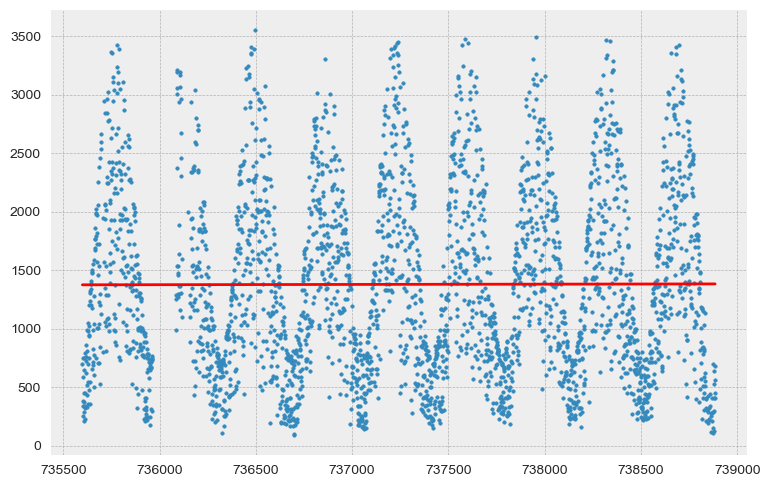

In [314]:
df_nan = df.loc[:,['date','05792_FG_STRAHL']].dropna()
df_nan.loc[:,'date']=df_nan.loc[:,'date'].map(pd.Timestamp.toordinal)
xn, yn = df_nan['date'],df_nan['05792_FG_STRAHL']
df_nan.loc[:,'date']=df_nan.loc[:,'date'].map(pd.Timestamp.fromordinal)

plt.scatter(xn, yn,s=6)

#calculate equation for trendline
zn = np.polyfit(xn, yn, 1)
pn = np.poly1d(zn)

#add trendline to plot
plt.plot(xn, pn(xn),color='red')

from scipy.stats import linregress
linregress(xn, yn).slope

In [315]:
# imputing implausible values
r, c = np.where(df.iloc[:,:-3].isna())
for i in range(len(r)):
    # getting all SD, FG or FD columns if applicable (identical physical measurements in Bavaria)
    cols_na = [col for col in df.columns if col.endswith(str(df.columns[c[i]])[5:])]

    # getting the median of specific day from corresponding columns
    med_row = df.loc[(df.index==r[i]) & (df['date'].dt.day==(df.iloc[r[i],0].day)) & (df['date'].dt.month==(df.iloc[r[i],0].month)),cols_na].sum().median()

    # getting the median of NaN column for specific day of the year
    med_col = df.loc[(df['date'].dt.day==(df.iloc[r[i],0].day)) & (df['date'].dt.month==(df.iloc[r[i],0].month)),df.columns[c[i]]].median()
    
    # calculating mean of both medians
    mean_v = np.nanmean(np.array([med_col,med_row]))

    # imputing
    df.iloc[r[i],c[i]] = mean_v

df.isna().sum()

date               0
03668_FD_STRAHL    0
03668_FG_STRAHL    0
03668_SD_STRAHL    0
05792_FD_STRAHL    0
05792_FG_STRAHL    0
05792_SD_STRAHL    0
05856_FD_STRAHL    0
05856_FG_STRAHL    0
05856_SD_STRAHL    0
05705_FD_STRAHL    0
05705_FG_STRAHL    0
05705_SD_STRAHL    0
02290_FD_STRAHL    0
02290_FG_STRAHL    0
02290_SD_STRAHL    0
05404_FD_STRAHL    0
05404_FG_STRAHL    0
05404_SD_STRAHL    0
Bruttoleistung     0
Nettoleistung      0
Act_in_MW          0
dtype: int64

<Axes: xlabel='date'>

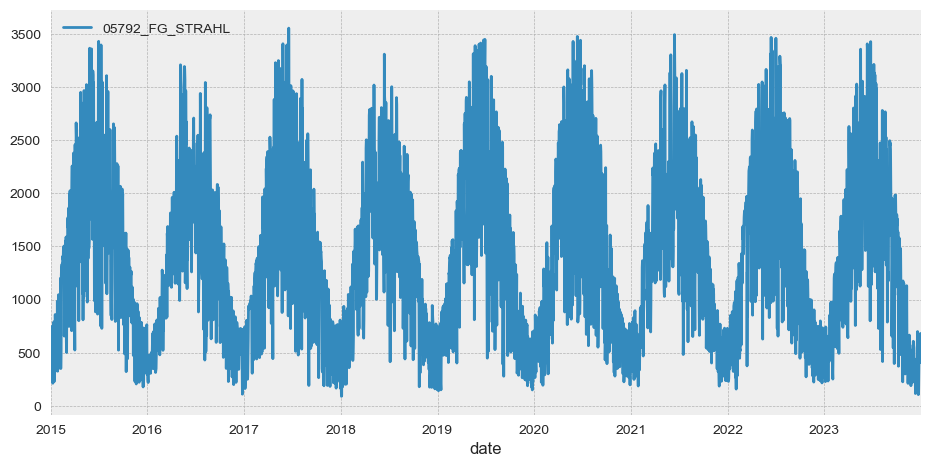

In [316]:
display(df.plot(x='date',y='05792_FG_STRAHL',figsize=(10,5))) #with imputed values 

-0.004016395634810569

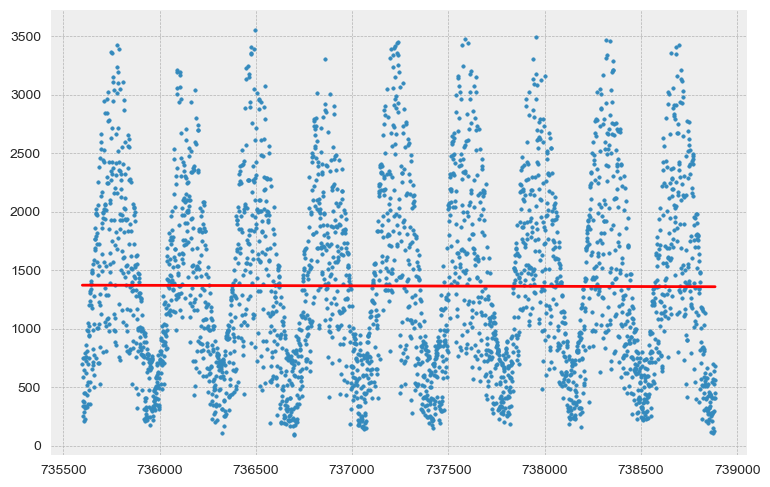

In [317]:
df.loc[:,'date']=df.loc[:,'date'].map(pd.Timestamp.toordinal)
x, y = df['date'],df['05792_FG_STRAHL']
df.loc[:,'date']=df.loc[:,'date'].map(pd.Timestamp.fromordinal)
plt.scatter(x, y,s=6)

#calculate equation for trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x, p(x),color='red')

from scipy.stats import linregress
linregress(x, y).slope


Difference in Brutto MW of extracted data and direct information from website: 34725 ( 0.002 %)
Difference in Netto MW of extracted data and direct information from website: 29820 ( 0.001 %)


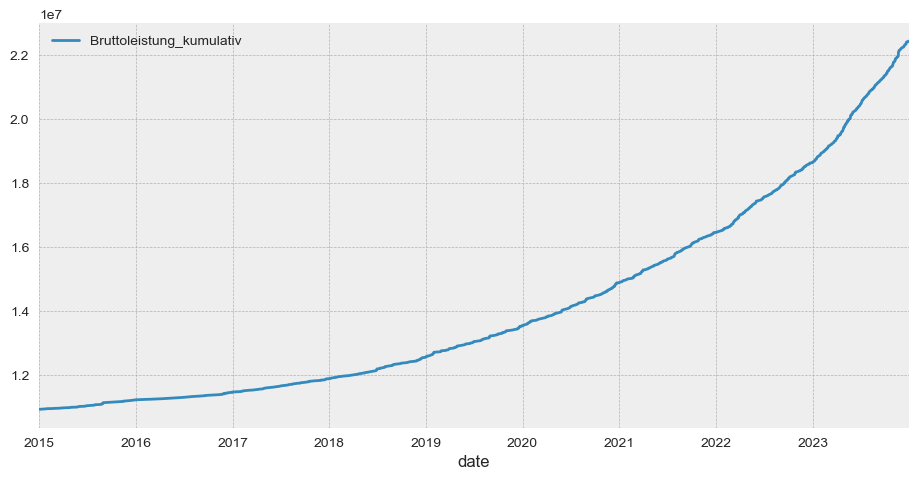

In [318]:
# manually gathered from http://www.marktstammdatenregister.de/MaStR/Einheit/Einheiten/OeffentlicheEinheitenuebersicht?filter=Inbetriebnahmedatum%20der%20Einheit~lt~%2701.01.2015%27~and~Energietr%C3%A4ger~eq~%272495%27~and~Bundesland~eq~%271403%27
# brutto vor 2015: 10.941.816 kW
# netto vor 2015: 10.135.888 kW

# creating new features for cumulative area of solarmodules for each day
df.loc[:,'Bruttoleistung_kumulativ'] = df.loc[:,'Bruttoleistung'].cumsum()+10941816
df.loc[:,'Nettoleistung_kumulativ'] = df.loc[:,'Nettoleistung'].cumsum()+10135888

# brutto vor 2024: 22.454.441 kW
# netto vor 2024: 20.404.484 kW
print('Difference in Brutto MW of extracted data and direct information from website:',22454441-round(df.iloc[-1,-2]),'(',round((22454441-round(df.iloc[-1,-2]))/22454441,3),'%)')
print('Difference in Netto MW of extracted data and direct information from website:',20404484-round(df.iloc[-1,-1]),'(',round((20404484-round(df.iloc[-1,-1]))/20404484,3),'%)')

# development of area of solarmodules from 2015-2023
df.plot(x='date',y='Bruttoleistung_kumulativ',figsize=(10,5)) 

df.to_csv('../Dataset/preprocessed_data/df_solar_energy_2015_2023.csv')

<Axes: xlabel='date'>

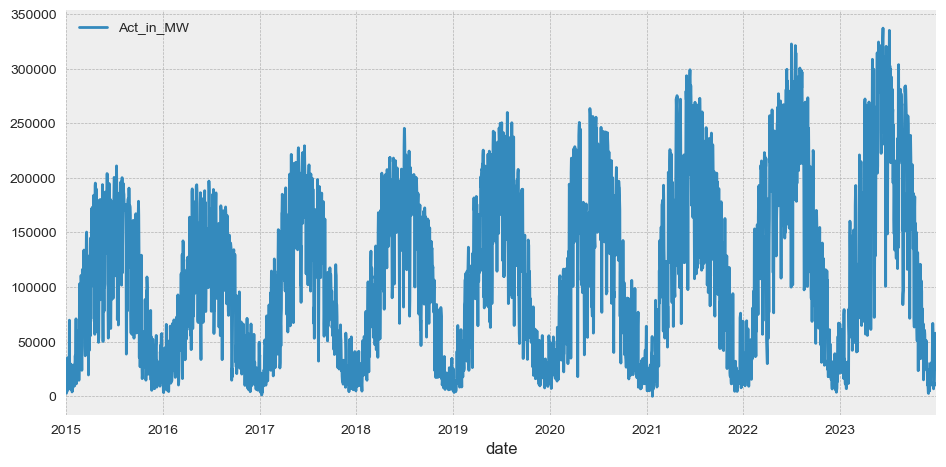

In [319]:
df_raw.plot(x='date',y='Act_in_MW',figsize=(10,5)) 

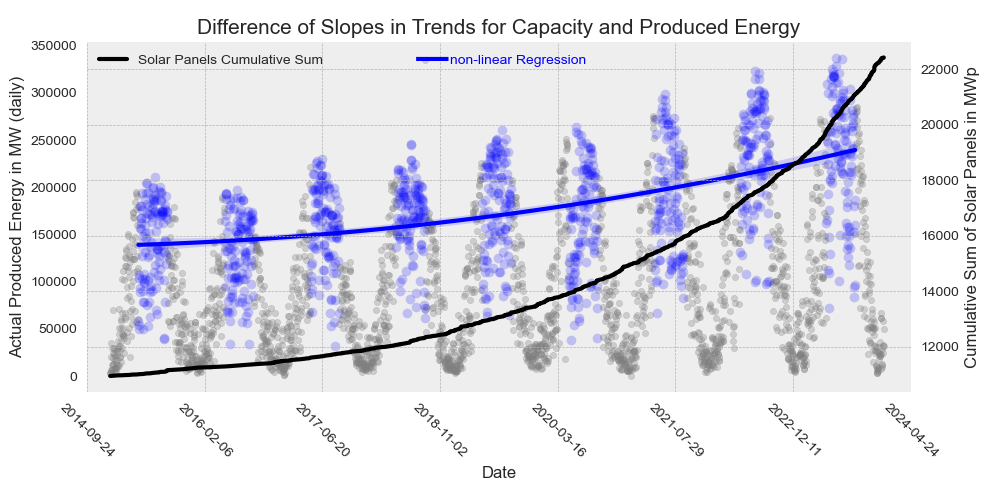

In [320]:
summer = (df['date'].dt.month <= 8) & (df['date'].dt.month >= 5)
df.loc[:,'Bruttoleistung_kumulativ'] = df.loc[:,'Bruttoleistung_kumulativ']/1000
fig, ax1 = plt.subplots(figsize=(10,5))
df.loc[:,'date']=df.loc[:,'date'].map(pd.Timestamp.toordinal) #converting date from timestamp to ordinal
df_s = df.loc[summer,:]
df.loc[~summer,:].plot.scatter(x='date',y='Act_in_MW',ax=ax1,alpha=0.3,fontsize=10,color='grey',label='non-linear Regression')
ax1.grid(visible=None, which='major', axis='y')
sns.regplot(data=df_s, x='date', y='Act_in_MW',ax=ax1, color='blue',order=2, scatter_kws={'alpha': 0.2})
ax1.legend(loc=9,labelcolor='blue')
plt.ylabel("Actual Produced Energy in MW (daily)",fontsize=12) 
plt.xlabel("Date",fontsize=12) 
ax1.set_xlim(df.iloc[0,0], df.iloc[-1,0])
ax2 = ax1.twinx()
plt.title('Difference of Slopes in Trends for Capacity and Produced Energy',fontsize=15)
df.plot(x='date',y='Bruttoleistung_kumulativ',ax=ax2,color='black',label='Solar Panels Cumulative Sum',fontsize=10,lw=3) 
ax2.ticklabel_format(useOffset=False, style='plain')
xticks = ax1.get_xticks()
labels = [pd.Timestamp.fromordinal(int(label)).date() for label in xticks]
ax1.set_xticks(xticks)
ax1.xaxis.set_tick_params(labelrotation=-45)
ax1.set_xticklabels(labels,fontsize=10)
plt.ylabel("Cumulative Sum of Solar Panels in MWp",fontsize=12) 
df.loc[:,'date']=df.loc[:,'date'].map(pd.Timestamp.fromordinal) #converting date back to timestamp from ordinal
df.loc[:,'Bruttoleistung_kumulativ'] = df.loc[:,'Bruttoleistung_kumulativ']*1000
ax2.annotate(xy=(736750, 22700), text='_',fontsize=40,color='blue',xytext=(736900, 22700))
fig.tight_layout()
plt.show()

In [322]:
df.loc[:,['date','05404_SD_STRAHL', '05404_FD_STRAHL', '05404_FG_STRAHL', 'Act_in_MW','Bruttoleistung','Bruttoleistung_kumulativ']]

,date,05404_SD_STRAHL,05404_FD_STRAHL,05404_FG_STRAHL,Act_in_MW,Bruttoleistung,Bruttoleistung_kumulativ
0,2015-01-01,1.90,365.00,426.00,2807.70,302.87,10942118.87
1,2015-01-02,2.00,233.00,281.00,2813.00,926.05,10943044.92
2,2015-01-03,0.00,194.00,196.00,6713.30,20.23,10943065.15
3,2015-01-04,0.00,182.00,183.00,4321.50,0.00,10943065.15
4,2015-01-05,1.80,344.00,392.00,20532.60,502.85,10943567.99
...,...,...,...,...,...,...,...
3282,2023-12-27,6.10,167.00,495.00,57761.50,3113.09,22402075.68
3283,2023-12-28,2.70,258.00,324.00,31177.60,2060.98,22404136.66
3284,2023-12-29,1.60,246.00,288.00,32275.70,13647.76,22417784.42
3285,2023-12-30,4.30,272.00,465.00,49406.90,1629.46,22419413.89
